# Predicting Credit Card Defaulting with Logistic Regression / a Neural Network

Implementation of logistic regression/neural network for predicting whether or not someone defaults on their credit card payment (a binary classification task).

### Install/import required libraries

In [33]:
# matplotlib.pyplot for plotting graphs, pandas for importing data, numpy for storing data & manually training models,
# keras for training models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.optimizers import SGD

### Load and Fix Up Data

In this function we:
* load the data into an array (from a pandas dataframe)
* filter out invalid entries
* remove the first column (id number)

In [34]:
# function that loads data, removes 1st column, invalid entries
def get_data():
  
  # get data into dataframe
  dataframe = pd.read_excel(io='default of credit card clients.xls', header=1)
  
  # turn dataframe into array
  data_array = pd.DataFrame.as_matrix(dataframe)
  
  # use list to filter out entries with invalid values for sex, education, or marriage
  data_list = []
  for i in range(data_array.shape[0]):
    if (data_array[i,2] in [1,2]) and (data_array[i,3] in [1,2,3,4]) and (data_array[i,4] in [1,2,3]): 
          data_list.append(data_array[i])
  
  # reset data array to only have correct entries
  data_array = np.asarray(data_list)
  
  # remove first column
  data_array = data_array[:,1:]
  
  return data_array

### Preprocessing the Data for Non-Tree Based Models

* If we're doing logistic regression/using a neural network, categorical data needs to be one-hot encoded. Fields for which we must use a one-hot encoding are:
  * sex - this is 1 or 2. 1 will become [1, 0], 2 will become [0, 1].
  * education - this is 1, 2, 3, or 4. 1 will become [1, 0, 0, 0], 2 will become [0, 1, 0, 0], and so on.
  * marriage - this is 1, 2, or 3 - it is one-hot encoded in the same way as sex and education.

In [35]:
# function that preprocesses the data for non-tree based models
def preprocess_for_LR_or_NN(data):
  
  # Get data for sex, education and marriage into separate numpy arrays:
  sex = data[:,1] 
  education = data[:,2] 
  marriage = data[:,3] 
  
  # Convert data into one-hot form for each
  sex_onehot = np.zeros((data.shape[0], 2))
  education_onehot = np.zeros((data.shape[0], 4))
  marriage_onehot = np.zeros((data.shape[0], 3))
  for i in range(data.shape[0]):
    sex_onehot[i, data[i,1]-1] = 1
    education_onehot[i, data[i,2]-1] = 1
    marriage_onehot[i, data[i,3]-1] = 1
  
  # set up new data with one-hot encoding features:
  one_hot_data = np.zeros((data.shape[0], 30))
  one_hot_data[:,0] = data[:,0] # id and limit balance stay as they were
  one_hot_data[:,1:3] = sex_onehot
  one_hot_data[:,3:7] = education_onehot
  one_hot_data[:,7:10] = marriage_onehot
  one_hot_data[:,10:30] = data[:,4:24] # remaining features stay as they were
  
  return one_hot_data

### Augmenting the Data
There are lots of data for label 0 (non-default) but not as much for label 1 (default). In this function, we duplicate data for label 1 until there are roughly as many datapoints for each label.

In [36]:
# function that augments default data (data with label 1)
def augment_default_data(data):
  
  # get the default, non-default data separately
  def_data = np.asarray([row for row in data if row[data.shape[1]-1]==1])
  non_def_data = np.asarray([row for row in data if row[data.shape[1]-1]==0])
  
  # get roughly how many times more non-default data there is than default data
  times_more = np.round((len(non_def_data)/len(def_data)), decimals=1)
  
  # duplicate default data, put it together until we have enough
  augmented_def_data = np.tile(def_data, (int(times_more),1))
  random_xtra = np.random.permutation(len(def_data))[:(int(len(def_data)*(times_more-int(times_more))))]
  augmented_def_data = np.concatenate((augmented_def_data, augmented_def_data[random_xtra]), axis=0)
  
  # put the data back together into a single array
  augmented_data = np.concatenate((augmented_def_data, non_def_data), axis=0)
  
  return augmented_data

### Train-Test/Train-Validation-Test Split

Here we split the data 2 or 3 ways, and separate features and labels into different arrays.

In [37]:
# function to split the data 2 or 3 ways, and separate out features and labels
def data_split(data, split):
  
  # if splitting 2 ways
  if len(split) == 2:
    
    # get random train-test split according to ratio specified
    rand_ordering = np.random.permutation(data.shape[0])
    num_train = int((split[0]/100) * data.shape[0])
    num_test = int((split[1]/100) * data.shape[0])
    
    # split up the data
    x_train = data[rand_ordering[:num_train],:(data.shape[1]-1)]
    y_train = data[rand_ordering[:num_train],(data.shape[1]-1)]
    x_test = data[rand_ordering[num_train:],:(data.shape[1]-1)]
    y_test = data[rand_ordering[num_train:],(data.shape[1]-1)]
    
    return x_train, y_train, x_test, y_test
  
  # if splitting 3 ways
  else:
    
    # get random train-validation-test split according to ratio specified
    rand_ordering = np.random.permutation(data.shape[0])
    num_train = int((split[0]/100) * data.shape[0])
    num_validation = int((split[1]/100) * data.shape[0])
    n_test = int((split[2]/100) * data.shape[0])
    
    # split up the data
    x_train = data[rand_ordering[:num_train],:(data.shape[1]-1)]
    y_train = data[rand_ordering[:num_train],(data.shape[1]-1)]
    x_validation = data[rand_ordering[num_train:(num_train+num_validation)],:(data.shape[1]-1)]
    y_validation = data[rand_ordering[num_train:(num_train+num_validation)],(data.shape[1]-1)]
    x_test = data[rand_ordering[(num_train+num_validation):],:(data.shape[1]-1)]
    y_test = data[rand_ordering[(num_train+num_validation):],(data.shape[1]-1)]
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

### Preprocessing the Training Data (Normalizing)

If we're doing logistic regression/using a neural network, we need to normalize our training data. Normalization is making sure all the features in the input vectors (rows of data) that will go into our model have a similar scale. Without going into much detail, the updates produced by gradient descent for model parameters are very sensitive to the scale of the input features the parameters are applied to - if the features have very different scales, it is harder for parameters to converge. Thus normalizing makes it easier to train logistic regression/neural networks in practice. Only in the case of decision trees does the scale of features not matter.

In [38]:
# function takes training & test features, scales both using the mean & standard deviation of the training features
def normalize(x_train, x_test):
  
  # get the mean and standard deviation for every feature in the training data
  x_train_mean = np.mean(x_train, axis=0)
  x_train_stdev = np.std(x_train, axis=0)
  
  # normalize/standardize the data by subtracting mean, dividing by standard deviation for every feature in the training data
  x_train_scaled = (x_train - x_train_mean)/x_train_stdev
  
  # we map the test data into the same domain as the training data
  x_test_scaled = (x_test - x_train_mean)/x_train_stdev
  
  return x_train_scaled, x_test_scaled

### Numpy Implementation of Logistic Regression

Logistic regression is equiv. to a neural network with an input of 29 neurons (one for each feature in the input vectors) that feeds into a single output neuron. 

The following function manually implements logistic regression - it builds the model, trains it for the specified number of epochs (and with the specified learning rate), and reports back error on the training and test sets. 

In [39]:
# function that manually implements logistic regression
def numpy_logistic_regression(x_train, y_train, x_test, y_test, num_epochs, learning_rate):
  
  # set up logistic regression parameters - a single weight vector (one weight for each feature) & a bias term
  weights = 0.1 * np.random.randn(x_train.shape[1])
  bias = 0.1 * np.random.randn(1)
  
  # keep track of mean squared errors, classification errors on the training & test data while training
  train_mses = np.zeros((num_epochs, x_train.shape[0]))
  train_errors = np.zeros((num_epochs, x_train.shape[0]))
  test_error_per_epoch = np.zeros(num_epochs)
  
  # train the model using SGD (this loop is essentially a "model.fit" type call)
  for epoch in range(num_epochs):
    
    for trial in range(x_train.shape[0]):
      
      # get the input features, output label for the current entry
      curr_input = x_train[trial]
      curr_label = y_train[trial]
      
      # calculate the model's prediction
      weighted_biased_input = weights.dot(curr_input) + bias # w*x + b
      prediction = 1/(1 + np.exp(-weighted_biased_input)) # sigmoid applied to (w*x + b)
      
      # compute mean squared error & classification error for model prediction, save them
      mse = np.square(prediction - curr_label)
      train_mses[epoch, trial] = mse
      if np.round(prediction, decimals=0) != curr_label: train_errors[epoch, trial] = 1
      
      # adjust model parameters based on the model's prediction error
      prediction_error = 2 * (prediction - curr_label)
      weighted_biased_input_error = prediction * (1 - prediction)
      
      weights_error = prediction_error * weighted_biased_input_error * curr_input
      bias_error = prediction_error * weighted_biased_input_error
      
      weights -= learning_rate * weights_error
      bias -= learning_rate * bias_error
    
    # compute classification error on test set for current epoch
    test_predictions = np.round((1/(1 + np.exp(-(weights.dot(x_test.transpose()) + bias)))), decimals=0)
    test_error = (len([pred for pred, actual in zip(test_predictions, y_test) if pred!=actual])/len(y_test))
    test_error_per_epoch[epoch] = test_error
  
  # compute mse on the training set for each epoch
  train_mse_per_epoch = np.mean(train_mses, axis=1)
  
  # compute classification error on the training set for each epoch
  train_error_per_epoch = np.mean(train_errors, axis=1)
  
  return train_mse_per_epoch, train_error_per_epoch, test_error_per_epoch

### Numpy Implementation of a Neural Network

The network has an input layer of 29 neurons, which feeds into a hidden layer of 29 neurons, which then feeds into an output of one neuron. 

The following function does the same thing for a neural network that the previous did for logistic regression.

In [40]:
# function that manually implements logistic regression
def numpy_neural_network(x_train, y_train, x_test, y_test, num_epochs, learning_rate):
  
  # set up neural net parameters
  weights_h = 0.1 * np.random.randn(x_train.shape[1], x_train.shape[1])
  b_h = 0.1 * np.random.randn(x_train.shape[1])
  weights_o = 0.1 * np.random.randn(x_train.shape[1])
  b_o = 0.1 * np.random.randn(1)
  
  # keep track of mean squared errors, classification errors on the training & test data while training
  train_mses = np.zeros((num_epochs, x_train.shape[0]))
  train_errors = np.zeros((num_epochs, x_train.shape[0]))
  test_error_per_epoch = np.zeros(num_epochs)
  
  # train the model using SGD (this loop is your call to "model.fit")
  for epoch in range(num_epochs):
    
    for trial in range(x_train.shape[0]):
      
      # get the input features, output label for the current entry
      curr_input = x_train[trial]
      curr_label = y_train[trial]
      
      # compute prediction for current datapoint
      hidden_preactivations = weights_h.dot(curr_input) + b_h
      hidden_activations = 1/(1 + np.exp(-hidden_preactivations))
      prediction_preactivation = weights_o.dot(hidden_activations) + b_o
      prediction = 1/(1 + np.exp(-prediction_preactivation))
      
      # compute mean squared error & classification error for model prediction, save them
      mse = np.square(prediction - curr_label)
      train_mses[epoch, trial] = mse
      if np.round(prediction, decimals=0) != curr_label: train_errors[epoch, trial] = 1
      
      # adjust model parameters based on the model's prediction error
      prediction_error = 2 * (prediction - curr_label)
      prediction_preactivation_error = prediction * (1 - prediction)
      hidden_activations_error = prediction_error * prediction_preactivation_error * weights_o
      hidden_preactivations_error = hidden_activations * (1 - hidden_activations)
      
      weights_o_error = prediction_error * prediction_preactivation_error * hidden_activations
      b_o_error = prediction_error * prediction_preactivation_error
      weights_h_error = np.matmul(np.expand_dims((hidden_activations_error * hidden_preactivations_error), axis=1),
                                  np.expand_dims(curr_input, axis=0))
      b_h_error = hidden_activations_error * hidden_preactivations_error
      
      weights_o -= learning_rate * weights_o_error
      b_o -= learning_rate * b_o_error
      weights_h -= learning_rate * weights_h_error
      b_h -= learning_rate * b_h_error
    
    # compute classification error on test set for current epoch
    test_hidden_activations = np.round((1/(1 + np.exp(-(weights_h.dot(x_test.transpose()) + np.expand_dims(b_h, 1))))),
                                       decimals=0)
    test_predictions = np.round(1/(1 + np.exp(-(weights_o.dot(test_hidden_activations + b_o)))), decimals=0)
    test_error = (len([pred for pred, actual in zip(test_predictions, y_test) if pred!=actual])/len(y_test))
    test_error_per_epoch[epoch] = test_error
  
  # compute mse on the training set for each epoch
  train_mse_per_epoch = np.mean(train_mses, axis=1)
  
  # compute classification error on the training set for each epoch
  train_error_per_epoch = np.mean(train_errors, axis=1)
  
  return train_mse_per_epoch, train_error_per_epoch, test_error_per_epoch

### Keras Implementation of Models

Simple implementation of Logistic Regression/a Neural Network using Keras - calls to Keras's API handle the creation of model parameters, model training, and saving model accuracy over time. 

In [44]:
# function that creates and trains model in keras
def keras_model(x_train, y_train, x_test, y_test, num_epochs, learning_rate, net):
  
  # model
  model = Sequential()
  if net == False:
    model.add(Dense(output_dim=1, input_dim=x_train.shape[1], activation='sigmoid'))
  else:
    model.add(Dense(output_dim=x_train.shape[1], input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(output_dim=1, input_dim=x_train.shape[1], activation='sigmoid'))
  
  # optimizer, loss metric
  optim = SGD(lr=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=optim, metrics=['accuracy'])
  
  # train
  fit = model.fit(x=x_train, y=y_train, epochs=num_epochs, verbose=1, 
                  batch_size=128, validation_data=(x_test, y_test))
  
  return fit.history['acc'], fit.history['val_acc']

### Plotting Results

For plotting a model's accuracy over time.

In [45]:
# function that plots train and test accuracy over epochs
def plot_utility(train_history, test_history, model_type):
  
  plt.plot(train_history)
  plt.plot(test_history)
  plt.title(model_type + " accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Putting Stuff Together

Here we call all the above functions to get and preprocess the data, train models with it, and plot the results.

NUMPY IMPLEMENTATION OF LOGISTIC REGRESSION


Average MSE on training set for every epoch (logistic regression): 
[ 0.21473314  0.20998181  0.20971026  0.20957545  0.20948817  0.20942523
  0.20937662  0.20933741  0.20930484  0.20927727]


Classfn accuracy on training set for every epoch (logistic regression): 
[ 0.66576308  0.68059095  0.68094335  0.68023855  0.68061805  0.68064516
  0.68129574  0.68137707  0.68121442  0.68126864]


Classfn accuracy on test set for every epoch (logistic regression): 
[ 0.67060609  0.67331671  0.67255774  0.67244931  0.67223246  0.67212404
  0.67266616  0.67169034  0.67244931  0.67255774]




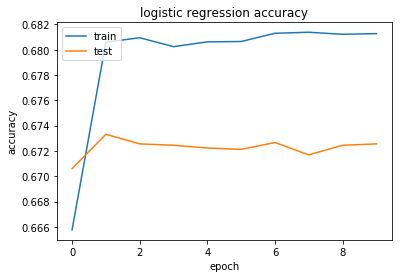



KERAS IMPLEMENTATION OF LOGISTIC REGRESSION




/Users/karan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=29, activation="sigmoid", units=1)`
  import sys


Train on 36890 samples, validate on 9223 samples
Epoch 1/10
36890/36890 [==============================] - 1s 20us/step - loss: 0.2547 - acc: 0.5782 - val_loss: 0.2436 - val_acc: 0.5921
Epoch 2/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2335 - acc: 0.6179 - val_loss: 0.2324 - val_acc: 0.6144
Epoch 3/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2255 - acc: 0.6365 - val_loss: 0.2272 - val_acc: 0.6275
Epoch 4/10
36890/36890 [==============================] - 0s 8us/step - loss: 0.2214 - acc: 0.6477 - val_loss: 0.2241 - val_acc: 0.6368
Epoch 5/10
36890/36890 [==============================] - 0s 12us/step - loss: 0.2187 - acc: 0.6535 - val_loss: 0.2220 - val_acc: 0.6407
Epoch 6/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2169 - acc: 0.6579 - val_loss: 0.2204 - val_acc: 0.6443
Epoch 7/10
36890/36890 [==============================] - 0s 11us/step - loss: 0.2156 - acc: 0.6618 - val_loss: 0.2192 - val_acc: 0.6

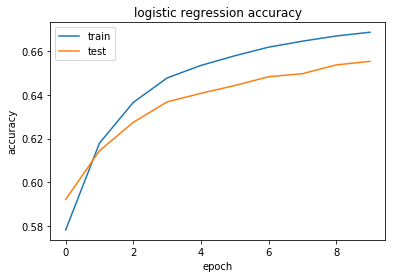



NUMPY IMPLEMENTATION OF A 1-HIDDEN LAYER NEURAL NETWORK


Average MSE on training set for every epoch (neural network): 
[ 0.23648434  0.21897519  0.21384346  0.21133504  0.20987258  0.20903066
  0.20849847  0.20809186  0.2077206   0.20734286]


Classfn accuracy on training set for every epoch (neural network): 
[ 0.6291678   0.65787476  0.66340472  0.66963947  0.67525075  0.67812415
  0.6793711   0.68159393  0.68240716  0.6832746 ]


Classfn accuracy on test set for every epoch (neural network): 
[ 0.64490947  0.65000542  0.65488453  0.66019733  0.66399219  0.66648596
  0.66529329  0.66702808  0.66735336  0.6688713 ]




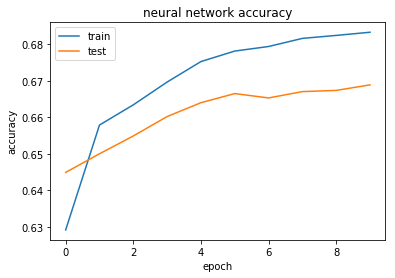



KERAS IMPLEMENTATION OF A 1-HIDDEN LAYER NEURAL NETWORK


Train on 36890 samples, validate on 9223 samples

/Users/karan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=29, activation="sigmoid", units=29)`
  if __name__ == '__main__':
/Users/karan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=29, activation="sigmoid", units=1)`
  # Remove the CWD from sys.path while we load stuff.



Epoch 1/10
36890/36890 [==============================] - 1s 15us/step - loss: 0.2487 - acc: 0.5392 - val_loss: 0.2433 - val_acc: 0.5788
Epoch 2/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2397 - acc: 0.5948 - val_loss: 0.2368 - val_acc: 0.6075
Epoch 3/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2338 - acc: 0.6210 - val_loss: 0.2322 - val_acc: 0.6246
Epoch 4/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2297 - acc: 0.6381 - val_loss: 0.2289 - val_acc: 0.6342
Epoch 5/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2267 - acc: 0.6448 - val_loss: 0.2265 - val_acc: 0.6399
Epoch 6/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2243 - acc: 0.6493 - val_loss: 0.2247 - val_acc: 0.6421
Epoch 7/10
36890/36890 [==============================] - 0s 9us/step - loss: 0.2225 - acc: 0.6532 - val_loss: 0.2233 - val_acc: 0.6460
Epoch 8/10
36890/36890 [======================

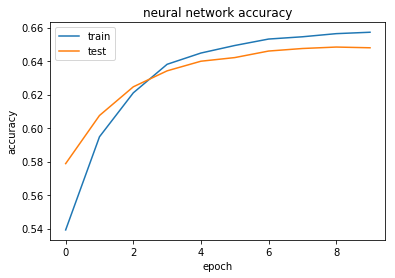

In [47]:
# Prep the data ---------------------------------------------------------------------------------------------------

data = get_data()
data = preprocess_for_LR_or_NN(data)
data = augment_default_data(data)
x_train, y_train, x_test, y_test = data_split(data, [80, 20])
x_train, x_test = normalize(x_train, x_test)


# Train logistic regression with numpy ----------------------------------------------------------------------------

print("NUMPY IMPLEMENTATION OF LOGISTIC REGRESSION")
print("\n")

learning_rate = 0.001
epochs = 10
lr_train_mse_per_epoch, lr_train_error_per_epoch, lr_test_error_per_epoch = numpy_logistic_regression(x_train, 
                                                                                                      y_train,
                                                                                                      x_test,
                                                                                                      y_test,
                                                                                                      epochs,
                                                                                                      learning_rate)

# print errors & accuracies
print("Average MSE on training set for every epoch (logistic regression): ")
print(lr_train_mse_per_epoch)
print("\n")

print("Classfn accuracy on training set for every epoch (logistic regression): ")
print(1 - lr_train_error_per_epoch)
print("\n")

print("Classfn accuracy on test set for every epoch (logistic regression): ")
print(1 - lr_test_error_per_epoch)
print("\n")

# plot training, test accuracy over time
plot_utility(1 - lr_train_error_per_epoch, 1 - lr_test_error_per_epoch, "logistic regression")
print("\n")


# Train logistic regression with keras ----------------------------------------------------------------------------

print("KERAS IMPLEMENTATION OF LOGISTIC REGRESSION")
print("\n")

learning_rate = 0.01
epochs = 10
lr_train_acc_per_epoch, lr_test_acc_per_epoch = keras_model(x_train, 
                                                            y_train,
                                                            x_test,
                                                            y_test,
                                                            epochs,
                                                            learning_rate,
                                                            net=False)

print(lr_train_acc_per_epoch)

# print errors & accuracies
print("Classfn accuracy on training set for every epoch (logistic regression): ")
print(lr_train_acc_per_epoch)
print("\n")

print("Classfn accuracy on test set for every epoch (logistic regression): ")
print(lr_test_acc_per_epoch)
print("\n")

# plot training, test accuracy over time
plot_utility(lr_train_acc_per_epoch, lr_test_acc_per_epoch, "logistic regression")
print("\n")


# Train a neural network with numpy -------------------------------------------------------------------------------

print("NUMPY IMPLEMENTATION OF A 1-HIDDEN LAYER NEURAL NETWORK")
print("\n")

learning_rate = 0.001
epochs = 10
nn_train_mse_per_epoch, nn_train_error_per_epoch, nn_test_error_per_epoch = numpy_neural_network(x_train, 
                                                                                                 y_train,
                                                                                                 x_test,
                                                                                                 y_test,
                                                                                                 epochs,
                                                                                                 learning_rate)


# see errors & accuracies
print("Average MSE on training set for every epoch (neural network): ")
print(nn_train_mse_per_epoch)
print("\n")

print("Classfn accuracy on training set for every epoch (neural network): ")
print(1 - nn_train_error_per_epoch)
print("\n")

print("Classfn accuracy on test set for every epoch (neural network): ")
print(1 - nn_test_error_per_epoch)
print("\n")

# plot accuracy over time for neural network
plot_utility(1 - nn_train_error_per_epoch, 1 - nn_test_error_per_epoch, "neural network")
print("\n")


# Train a neural network with keras -------------------------------------------------------------------------------

print("KERAS IMPLEMENTATION OF A 1-HIDDEN LAYER NEURAL NETWORK")
print("\n")

learning_rate = 0.01
epochs = 10
nn_train_acc_per_epoch, nn_test_acc_per_epoch = keras_model(x_train, 
                                                            y_train,
                                                            x_test,
                                                            y_test,
                                                            epochs,
                                                            learning_rate,
                                                            net=True)

# print errors & accuracies
print("Classfn accuracy on training set for every epoch (neural network): ")
print(nn_train_acc_per_epoch)
print("\n")

print("Classfn accuracy on test set for every epoch (neural network): ")
print(nn_test_acc_per_epoch)
print("\n")

# plot training, test accuracy over time
plot_utility(nn_train_acc_per_epoch, nn_test_acc_per_epoch, "neural network")
print("\n")